In [10]:
import aind_cloud_fusion.blend as blend
import aind_cloud_fusion.fusion as fusion
import aind_cloud_fusion.geometry as geometry
import aind_cloud_fusion.io as io

import dask.array as da
import torch
import numpy as np

In [13]:
# Need a custom dataset. 
class ExaspimTestDataset(io.Dataset):
    @property
    def tile_volumes_zyx(self) -> dict[int, io.LazyArray]:
        # Assuming Dataset 'exaSPIM_659146' is mounted. 
        tile_1_path = '/root/capsule/data/exaSPIM_659146_2023-11-10_14-02-06/SPIM.ome.zarr/tile_x_0002_y_0001_z_0000_ch_488.zarr/5'
        tile_2_path = '/root/capsule/data/exaSPIM_659146_2023-11-10_14-02-06/SPIM.ome.zarr/tile_x_0002_y_0002_z_0000_ch_488.zarr/5'

        tile_arrays: dict[int, io.LazyArray] = {}
        for tile_id, t_path in enumerate([tile_1_path, tile_2_path]):
            tile_zarr = da.from_zarr(t_path)
            tile_zarr_zyx = tile_zarr[0, 0, :, :, :]
            tile_arrays[tile_id] = io.ZarrArray(tile_zarr_zyx)

        return tile_arrays

    @property
    def tile_transforms_zyx(self) -> dict[int, list[geometry.Transform]]:
        tile_transforms: dict[int, list[geometry.Transform]] = {}        
        tile_transforms[0] = [geometry.Affine(np.array([[1., 0., 0., 0.], 
                                                       [0., 1., 0., 0.],
                                                       [0., 0., 1., 0.]]))]
        tile_transforms[1] = [geometry.Affine(np.array([[1., 0., 0., 0.], 
                                                       [0., 1., 0., 281.25], 
                                                       [0., 0., 1., 0.]]))]
        return tile_transforms

    @property
    def tile_resolution_zyx(self) -> tuple[float, float, float]:
        return (1.0, 0.748, 0.748)


In [14]:
# Application Object: DATASET
DATASET = ExaspimTestDataset()

# Application Object: OUTPUT_PARAMS
OUTPUT_PARAMS = io.OutputParameters(
        path='fused_exaspim.zarr',
        chunksize=(1, 1, 100, 100, 100),
        resolution_zyx=(1.0, 0.748, 0.748),
)

# Application Object: RUNTIME PARAMS
# (Fill worker cells later)
RUNTIME_PARAMS = io.RuntimeParameters(
        use_gpus=False,
        devices=[torch.device("cpu")],
        pool_size=1
)

# Application Parameter: CELL_SIZE
CELL_SIZE = (100, 100, 100)

# Application Parameter: POST_REG_TFMS
POST_REG_TFMS: list[geometry.Affine] = []

# Application Object: BLENDING_MODULE
_, _, _, tile_aabbs, output_volume_size, _ = \
fusion.initialize_fusion(DATASET,
                         POST_REG_TFMS,
                         OUTPUT_PARAMS)
BLENDING_MODULE = blend.MaskedBlending(tile_aabbs=tile_aabbs, 
                                        cell_size=CELL_SIZE,
                                        mask_axes=[1], 
                                        mask_percent=0.9)

# Init and run fusion
worker_cells = []
z_cnt, y_cnt, x_cnt = fusion.get_cell_count_zyx(
        output_volume_size, CELL_SIZE
)
for z in range(z_cnt):
        for y in range(y_cnt):
                for x in range(x_cnt):
                        worker_cells.append((z, y, x))
RUNTIME_PARAMS.worker_cells = worker_cells

fusion.run_fusion(
        DATASET,
        OUTPUT_PARAMS,
        RUNTIME_PARAMS,
        CELL_SIZE,
        POST_REG_TFMS,
        BLENDING_MODULE,
)

2023-12-07 23:07 Number of Tiles: 2
2023-12-07 23:07 output_volume_size=(896, 614, 444)
2023-12-07 23:07 Starting Cell 0/315
2023-12-07 23:07 cell_box=array([  0, 100,   0, 100,   0, 100])
2023-12-07 23:07 overlapping_tiles=[0]
2023-12-07 23:07 AABB of Crop belonging to image 0:
        0, 100, 0, 100, 0, 100


f{TILE_LAYOUT.shape=}


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
2023-12-07 23:07 Finished Cell 0/315: 0.7798755168914795
2023-12-07 23:07 Starting Cell 1/315
2023-12-07 23:07 cell_box=array([  0, 100,   0, 100, 100, 200])
2023-12-07 23:07 overlapping_tiles=[0]
2023-12-07 23:07 AABB of Crop belonging to image 0:
        0, 100, 0, 100, 100, 200
2023-12-07 23:07 Finished Cell 1/315: 0.44766664505004883
2023-12-07 23:07 Starting Cell 2/315
2023-12-07 23:07 cell_box=array([  0, 100,   0, 100, 200, 300])
2023-12-07 23:07 overlapping_tiles=[0]
2023-12-07 23:07 AABB of Crop belonging to image 0:
        0, 100, 0, 100, 200, 300
2023-12-07 23:07 Finished Cell 2/315: 0.46620845794677734
2023-12-07 23:07 Starting Cell 3/315
2023-12-07 23:07 cell_box=array([

(896, 614, 444)


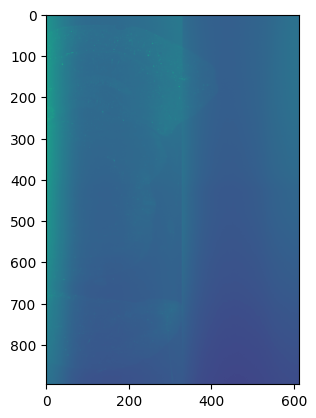

In [68]:
import matplotlib.pyplot as plt
import zarr

%matplotlib inline
output_path = "fused_exaspim.zarr/0"
arr = zarr.open(output_path, mode="r")
fused_data = arr[0, 0, :, :, :]

print(fused_data.shape)
plt.imshow(fused_data[:, :, 55])
plt.show()

(896, 333, 444)
(896, 333, 444)


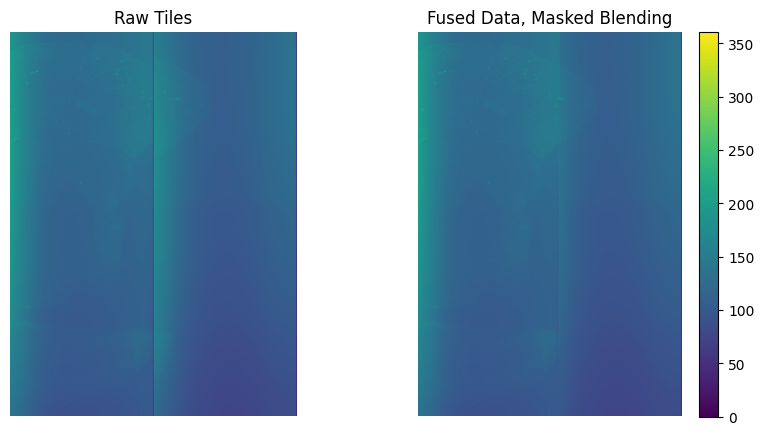

In [78]:
# Confused
# Let me plot the inividual tiles

t1 = DATASET.tile_volumes_zyx[0]
t2 = DATASET.tile_volumes_zyx[1]
print(t1.shape)
print(t2.shape)

i = 55
s = np.concatenate((t1[:, :, i], t2[:, :, i]), axis=1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
im = ax[0].imshow(s)
ax[0].set_title('Raw Tiles')
ax[0].axis('off')
im = ax[1].imshow(fused_data[:, :, i])
ax[1].set_title('Fused Data, Masked Blending')
ax[1].axis('off')
fig.colorbar(im, ax=ax[1])

fig.savefig('tests/exaspim_masked_blending.jpg')